# Dual CNN on protein-ligand template docking

In [1]:
!nvidia-smi

Wed Mar 23 17:34:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   60C    P0    60W / 240W |    512MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [4]:
dataset = 'oldsmiledata_id_processed_transformed_shuffled'

In [5]:
path = Path('../dataset/oldsmiledata')

In [6]:
list(path.iterdir())

[PosixPath('../dataset/oldsmiledata/test_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/oldsmiledata_id_processed_transformed_rescaled_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/.ipynb_checkpoints'),
 PosixPath('../dataset/oldsmiledata/mol_images'),
 PosixPath('../dataset/oldsmiledata/train_balanced_oldsmiledata.csv'),
 PosixPath('../dataset/oldsmiledata/valid_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_oldsmiledata_id_processed_transformed_shuffled.csv')]

In [7]:
#IMAGES = path/'mol_images'/'all'
train = pd.read_csv(path/f'train_balanced_{dataset}.csv')
valid = pd.read_csv(path/f'valid_balanced_{dataset}.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19139 entries, 0 to 19138
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      19139 non-null  int64  
 1   template                        19139 non-null  object 
 2   docked                          19139 non-null  object 
 3   rmsd                            19139 non-null  float64
 4   uniprot_id                      19139 non-null  object 
 5   smiles_template                 19139 non-null  object 
 6   smiles_docked                   19139 non-null  object 
 7   mcs_smartsString                19139 non-null  object 
 8   template_HeavyAtomCount         19139 non-null  int64  
 9   template_NHOHCount              19139 non-null  int64  
 10  template_NOCount                19139 non-null  int64  
 11  template_RingCount              19139 non-null  int64  
 12  template_NumHAcceptors          

In [9]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4785 entries, 0 to 4784
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      4785 non-null   int64  
 1   template                        4785 non-null   object 
 2   docked                          4785 non-null   object 
 3   rmsd                            4785 non-null   float64
 4   uniprot_id                      4785 non-null   object 
 5   smiles_template                 4785 non-null   object 
 6   smiles_docked                   4785 non-null   object 
 7   mcs_smartsString                4785 non-null   object 
 8   template_HeavyAtomCount         4785 non-null   int64  
 9   template_NHOHCount              4785 non-null   int64  
 10  template_NOCount                4785 non-null   int64  
 11  template_RingCount              4785 non-null   int64  
 12  template_NumHAcceptors          47

In [10]:
train.head()

,Unnamed: 0,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,...,mcs_docked_NumHDonors,mcs_template_NumRotatableBonds,mcs_docked_NumRotatableBonds,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,is_valid
0,0,1YPJ_UIB,1K22_MEL,4.643,P00734,CC[C@@H]1[C@@H]2[C@H](C(=O)N1Cc1ccc3c(c1)OCO3)...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#7]=[#6](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...,33,3,...,3,4,7,0.165775,0.289941,1.535361,3,-0.342246,-0.100592,False
1,1,2JH5_895,1C5O_BAM,3.209,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-[#6]:,-[#6]:,-[#6]",28,1,...,1,0,1,0.050847,0.059829,1.165959,3,-1.491525,-2.401709,False
2,2,5Y12_8JX,1TOW_CRZ,1.769,P15090,COc1ccc(S(=O)(=O)NCCCCC(=O)O)c2ccccc12,O=C(O)CCCn1c2ccccc2c2ccccc21,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:[#6]:[#6...,23,2,...,0,0,0,0.324561,0.324561,0.570414,1,1.245614,0.245614,False
3,3,1C1U_BAI,5AHG_Y4L,3.943,P00734,N=C(N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1,CN(C)S(=O)(=O)Nc1ccc(Cl)cc1,"[#7]-,:[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1",22,5,...,1,0,1,0.086957,0.106195,1.371942,3,-1.130435,-1.938053,False
4,4,2W26_RIV,2Y80_439,7.217,P00742,O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1...,CN(C)[C@@H]1CCc2cc(N3CC[C@H](NS(=O)(=O)c4ccc5c...,[#7]-[#6]-[#6]-[#6]-[#7](-[#6]1:[#6]:[#6]:[#6]...,29,1,...,1,3,2,0.187166,0.283237,1.976439,3,-0.128342,-0.167630,False


# Preprocessing building ImageDataGenerator

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint

2022-03-23 17:34:18.178386: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Splitting the data into train and validation sets

In [12]:
train['img_temp'] = train['template'] + '.png'
train['img_docked'] = train['docked'] + '.png'
train['is_valid'] = False
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19139 entries, 0 to 19138
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      19139 non-null  int64  
 1   template                        19139 non-null  object 
 2   docked                          19139 non-null  object 
 3   rmsd                            19139 non-null  float64
 4   uniprot_id                      19139 non-null  object 
 5   smiles_template                 19139 non-null  object 
 6   smiles_docked                   19139 non-null  object 
 7   mcs_smartsString                19139 non-null  object 
 8   template_HeavyAtomCount         19139 non-null  int64  
 9   template_NHOHCount              19139 non-null  int64  
 10  template_NOCount                19139 non-null  int64  
 11  template_RingCount              19139 non-null  int64  
 12  template_NumHAcceptors          

In [13]:
valid['img_temp'] = valid['template'] + '.png'
valid['img_docked'] = valid['docked'] + '.png'
valid['is_valid'] = True
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4785 entries, 0 to 4784
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      4785 non-null   int64  
 1   template                        4785 non-null   object 
 2   docked                          4785 non-null   object 
 3   rmsd                            4785 non-null   float64
 4   uniprot_id                      4785 non-null   object 
 5   smiles_template                 4785 non-null   object 
 6   smiles_docked                   4785 non-null   object 
 7   mcs_smartsString                4785 non-null   object 
 8   template_HeavyAtomCount         4785 non-null   int64  
 9   template_NHOHCount              4785 non-null   int64  
 10  template_NOCount                4785 non-null   int64  
 11  template_RingCount              4785 non-null   int64  
 12  template_NumHAcceptors          47

In [14]:
# image size 224,224
target_shape=(224, 224)

In [15]:
IMAGES = '../dataset/oldsmiledata/mol_images/all/'

In [16]:
def preprocess_image(filename):
    img_str = tf.io.read_file(IMAGES + filename)
    image = tf.image.decode_png(img_str, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    #image = tf.transpose(image)
    return image

In [17]:
%%capture
img_shape = preprocess_image(train.img_temp[0]).shape

2022-03-23 17:34:18.925571: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-23 17:34:18.926158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-23 17:34:18.973159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 17:34:18.974699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2022-03-23 17:34:18.974805: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-23 17:34:18.979309: I tensorflow/stream_executor/platform/d

In [18]:
img_shape

TensorShape([224, 224, 3])

In [57]:
def preprocess_doubles(template, docked):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (preprocess_image(template), preprocess_image(docked))
    

In [36]:
image = preprocess_image('/4A7I_A7I.png')
image.shape

TensorShape([224, 224, 3])

In [37]:
train_template_images = [r.img_temp for i, r in train.iterrows()]

In [38]:
train_docked_images = [r.img_docked for i, r in train.iterrows()]

In [39]:
len(train_template_images), len(train_docked_images)

(19139, 19139)

In [40]:
valid_template_images = [r.img_temp for i, r in valid.iterrows()]
valid_docked_images = [r.img_docked for i, r in valid.iterrows()]

In [41]:
image_count = len(train_template_images) + len(valid_template_images)
image_count

23924

In [42]:
template_dataset = tf.data.Dataset.from_tensor_slices(train_template_images)
docked_dataset = tf.data.Dataset.from_tensor_slices(train_docked_images)

In [43]:
val_template_dataset = tf.data.Dataset.from_tensor_slices(valid_template_images)
val_docked_dataset = tf.data.Dataset.from_tensor_slices(valid_docked_images)

In [44]:
y_train = train['log_RMSD']
y_train = tf.data.Dataset.from_tensor_slices(list(y_train))

In [45]:
y_valid = valid['log_RMSD']
y_valid = tf.data.Dataset.from_tensor_slices(list(y_train))

### Create the train and validation datasets

In [46]:
train_dataset = tf.data.Dataset.zip((template_dataset, docked_dataset)) # template as anchor
#train_dataset = tf.data.Dataset.zip((docked_dataset, template_dataset,  negative_dataset)) # docked as anchor
#train_dataset = tf.data.Dataset.zip((train_dataset, negative_dataset))
valid_dataset = tf.data.Dataset.zip((val_template_dataset, val_docked_dataset)) # template as anchor
#valid_dataset = tf.data.Dataset.zip((val_docked_dataset, val_template_dataset, val_negative_dataset)) # docked as anchor
#valid_dataset = tf.data.Dataset.zip((valid_dataset, val_negative_dataset))
train_dataset, valid_dataset

(<ZipDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <ZipDataset shapes: ((), ()), types: (tf.string, tf.string)>)

In [47]:
train_dataset = train_dataset.take(round(image_count * 1))
train_dataset

<TakeDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [48]:
train_dataset = train_dataset.map(preprocess_doubles)
val_dataset = valid_dataset.map(preprocess_doubles)
train_dataset, val_dataset

(<MapDataset shapes: ((224, 224, 3), (224, 224, 3)), types: (tf.float32, tf.float32)>,
 <MapDataset shapes: ((224, 224, 3), (224, 224, 3)), types: (tf.float32, tf.float32)>)

In [78]:
train_dl = train_dataset.batch(32, drop_remainder=True)
train_fetch = train_dl.prefetch(8)
train_fetch

<PrefetchDataset shapes: ((32, 224, 224, 3), (32, 224, 224, 3)), types: (tf.float32, tf.float32)>

In [81]:
val_dl = val_dataset.batch(32, drop_remainder=True)
val_pre = val_dl.prefetch(8)
val_pre

<PrefetchDataset shapes: ((32, 224, 224, 3), (32, 224, 224, 3)), types: (tf.float32, tf.float32)>

## Anchor, positive and the distance between them computed by the distance layer

2022-03-23 17:36:15.367061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-23 17:36:15.384458: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3999980000 Hz


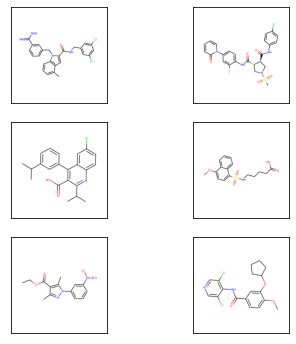

In [51]:
def visualize(anchor, positive):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    fig = plt.figure(figsize=(6, 6))

    axs = fig.subplots(3, 2)
    for i in range(0, 3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
    

visualize(*list(val_dl.take(1).as_numpy_iterator())[0])

# Dual CNN with concatenated layer

In [82]:
def create_convolution_layers(input_img):
    model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
    model = LeakyReLU(alpha=0.1)(model)
    model = MaxPooling2D((2, 2),padding='same')(model)
    model = Dropout(0.25)(model)
  
    model = Conv2D(64, (3, 3), padding='same')(model)
    model = LeakyReLU(alpha=0.1)(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    model = Dropout(0.25)(model)
    
    model = Conv2D(128, (3, 3), padding='same')(model)
    model = LeakyReLU(alpha=0.1)(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    model = Dropout(0.4)(model)
    
    return model

In [83]:
input_shape=(224, 224, 3)
num_classes = 2

In [84]:
current_input = Input(shape=input_shape)
current_model = create_convolution_layers(current_input)

voltage_input = Input(shape=input_shape)
voltage_model = create_convolution_layers(voltage_input)

conv = concatenate([current_model, voltage_model])

conv = Flatten()(conv)

dense = Dense(512)(conv)
dense = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[current_input, voltage_input], outputs=[output])

opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [85]:
best_weights_file="weights.best.hdf5"
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(train_dl, validation_data=val_dl, epochs=2, verbose=1)

Epoch 1/2


ValueError: in user code:

    /home/kjetil/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/kjetil/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/kjetil/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/kjetil/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/kjetil/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/kjetil/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/kjetil/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/kjetil/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/kjetil/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:204 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_6 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 224, 224, 3) dtype=float32>]


In [88]:
model(train_fetch)

TypeError: Inputs to a layer should be tensors. Got: <PrefetchDataset shapes: ((32, 224, 224, 3), (32, 224, 224, 3)), types: (tf.float32, tf.float32)>

### Choose optimizer and train model

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), metrics=[metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [ ]:
model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=5)

In [ ]:
model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=5)

In [ ]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pd.DataFrame(model.history).plot(figsize=(8,5))
print("Loss, validation loss and RMSE")
plt.show()

### Previous results: 
### loss: 0.315 - val_loss: 0.219 - RMSE: 0.7255 for 1 epoch 
### loss: 0.115 - val_loss: 0.123 - RMSE: 0.678 for 5 epochs 
### loss: 0. - val_loss. 0. - RMSE:  for 10 epochs 

## Inspecting what the network has learned

In [ ]:
sample = next(iter(val_dl))
visualize2(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pickle
#import sklearn, pandas as pd, seaborn as sn
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Load models
#model = embedding
siamese_model = siamese_model

names = next(iter(val_dl))

anchor, positive, negative = names
anchor = tf.reshape(anchor[0], (1, 224, 224, 3))
positive = tf.reshape(positive[0], (1, 224, 224, 3))
negative = tf.reshape(negative[0], (1, 224, 224, 3))


test_im = []
test_im.append(anchor)
test_im.append(positive)
test_im.append(negative)

print(test_im[0].shape)
_, r,c,_ = test_im[0].shape
print(test_im[0].shape)
test_im = np.array(test_im)
test_im = test_im.reshape((len(test_im), r,c,3))

test_im = 1 - test_im/255

# Predict
pred = model.predict([anchor, positive, negative])

print(pred)

num = int(pred.shape[0]/3)
colors = ['red', 'blue', 'green'] # set colors of target labels

# Set target labels
y = [colors[0] for i in range(num)]
y += [colors[1] for i in range(num)]
y += [colors[2] for i in range(num)]

feat1 = pred[:,0]
feat2 = pred[:,1]
feat3 = pred[:,2]

# Plot 3d scatter plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(feat1, feat2, feat3, c=y, marker='.')
plt.show()

# Parameter optimization 

## Adam vs SGD

In [ ]:
def create_embedding(dropout = None):
    base_cnn = resnet.ResNet50(
        weights="imagenet", input_shape=target_shape +  (3,), include_top=False
    )

    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    if dropout != None: 
        layer = layers.Dropout(dropout)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    return embedding

In [ ]:
def create_siamese_net(embedding):
    anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
    positive_input = layers.Input(name="positive", shape=target_shape + (3,))
    negative_input = layers.Input(name="negative", shape=target_shape + (3,))

    distances = DistanceLayer()(
        embedding(resnet.preprocess_input(anchor_input)),
        embedding(resnet.preprocess_input(positive_input)),
        embedding(resnet.preprocess_input(negative_input)),
    )

    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input], outputs=distances
    )

    return siamese_network

In [ ]:
def train_model(epochs = 5, lr=0.0001, dropout=None, verbose=False):
    embedding = create_embedding(dropout=dropout)
    siamese_network = create_siamese_net(embedding)
    siamese_model = SiameseModel(siamese_network)
    siamese_model.compile(optimizer=optimizers.Adam(learning_rate=lr), metrics=[metrics.RootMeanSquaredError(name='rmse')])
    model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=epochs)
    if verbose:
        plt.plot(model.history['loss'])
        plt.plot(model.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        plt.plot(model.history['val_rmse'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['rmse'], loc='upper left')
        plt.show()
    return siamese_model
        
    

In [ ]:
dropout = [None, 0.2, 0.5]

In [ ]:
for d in dropout:
    model = train_model(dropout=d)

In [ ]:
lrs = [0.0005, 0.0001, 0.00001]


In [ ]:
for lr in lrs:
    model = train_model(lr=lr, verbose = True)


# Test the model performance on instances

In [ ]:
model = train_model(lr=0.0001, epochs = 10)

In [ ]:
from tensorflow.keras import models
model.compute_output_shape(input_shape= [(None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)])                        

In [ ]:
model.save('models/siamese_model')

In [ ]:
model = models.load_model('models/siamese_model')

In [ ]:
sample = next(iter(val_dl))

In [ ]:
docked_sample = valid.iloc[0]
docked_sample.docked

In [ ]:
docked_image = preprocess_image(docked_sample.img_docked)

In [ ]:
templates = valid[valid.docked == docked_sample.docked]
templates = templates.reset_index()
templates = templates.sort_values(by=['rmsd'], ignore_index=True)
templates

In [ ]:
template_image = preprocess_image(templates.iloc[0].img_temp)

In [ ]:
plt.imshow(docked_image)

In [ ]:
plt.imshow(template_image)

In [ ]:
rmse = metrics.CosineSimilarity()

In [ ]:
template_image = tf.reshape(template_image, (1,224,224,3))

In [ ]:
docked_image = tf.reshape(docked_image, (1,224,224,3))

In [ ]:
template_embedding, docked_embedding = (
    embedding(resnet.preprocess_input(template_image)),
    embedding(resnet.preprocess_input(docked_image)),
)

In [ ]:
rmse_positive = rmse(template_embedding, docked_embedding)
rmse_positive.numpy(), templates.iloc[0].log_RMSD

In [ ]:
type(rmse_positive.numpy())

In [ ]:
def get_rmse(row):
    docked_image = preprocess_image(row.img_docked)
    template_image = preprocess_image(row.img_temp)
    template_image = tf.reshape(template_image, (1,224,224,3))
    docked_image = tf.reshape(docked_image, (1,224,224,3))
    template_embedding, docked_embedding = (
        embedding(resnet.preprocess_input(template_image)),
        embedding(resnet.preprocess_input(docked_image)),
    )
    rmse_positive = rmse(template_embedding, docked_embedding)
    return rmse_positive.numpy()

In [ ]:
rmses = {}
for i, r in templates.iterrows(): 
    rm = get_rmse(r)
    rmses[i] = rm
rmses

In [ ]:
rmses_sorted = sorted(rmses, key=rmses.get)
rmses_sorted

In [ ]:
rmses.index(min(rmses))

In [ ]:
templates.iloc[4].template

In [ ]:
for i, r in templates.iterrows():
    print(r)